<a href="https://colab.research.google.com/github/JoshuaTapp/CulturalEmotionClassifer/blob/main/Final_Project_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data and get Labels

In [1]:
from google.colab import drive
drive.mount("/content/drive/")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import zipfile
from google.colab import drive
import numpy as np
import pandas as pd
import os

from google.colab import drive

#import aligned image data
# ## CHANGE FILEPATH ##
#https://drive.google.com/drive/folders/0B4E10azXECctc3liOGpDOWcwMzA?resourcekey=0-NwbB0GgquW4Tb2XHgzcgQw
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/basic/Image/aligned.zip", 'r')
#zip_ref.extractall("/content/aligned")
#zip_ref.close()

#import label data
# ## CHANGE FILEPATH ##
#https://drive.google.com/drive/folders/0B4E10azXECctamJ1a05FWlJVbDg?resourcekey=0-j5KCeOXALENabx5nCPnXuQ
labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/basic/EmoLabel/list_patition_label.txt", sep=" ", header=None)


In [3]:
labels.head(10)

,0,1
0,train_00001.jpg,5
1,train_00002.jpg,5
2,train_00003.jpg,4
3,train_00004.jpg,4
4,train_00005.jpg,5
5,train_00006.jpg,1
6,train_00007.jpg,5
7,train_00008.jpg,4
8,train_00009.jpg,4
9,train_00010.jpg,1


In [4]:
#create labels in the same order as our folder
%cd /content/aligned/aligned/
traintestlabels = []

for filename in os.listdir("/content/aligned/aligned"):
    replace_name = filename.replace("_aligned", "")
    label = int( labels.loc[labels.index[labels[0] == replace_name].tolist(), 1] )
    os.rename(filename, replace_name)

    traintestlabels.append(label)

/content/aligned/aligned


KeyboardInterrupt: ignored

In [ ]:
%cd /content/aligned/
%mkdir labeled
%cd labeled/
%mkdir '1'
%mkdir '2'
%mkdir '3'
%mkdir '4'
%mkdir '5'
%mkdir '6'
%mkdir '7'

/content/aligned
/content/aligned/labeled


In [ ]:
pwd

'/content/aligned/labeled'

In [5]:
%cd /content/aligned/labeled/
from shutil import copy

open_txt = open('/content/drive/MyDrive/Colab Notebooks/basic/EmoLabel/list_patition_label.txt', 'r')

read_lines = open_txt.readlines()

c=0
for line in read_lines:
  words = line.split()
  #print(words[1])

  if words[1]=='1':
    copy('/content/aligned/aligned/'+words[0], words[1])
  elif words[1]=='2':
    copy('/content/aligned/aligned/'+words[0], words[1])
  elif words[1]=='3':
    copy('/content/aligned/aligned/'+words[0], words[1])
  elif words[1]=='4':
    copy('/content/aligned/aligned/'+words[0], words[1])
  elif words[1]=='5':
    copy('/content/aligned/aligned/'+words[0], words[1])
  elif words[1]=='6':
    copy('/content/aligned/aligned/'+words[0], words[1])
  elif words[1]=='7':
    copy('/content/aligned/aligned/'+words[0], words[1])
    

/content/aligned/labeled


# Model Building

In [6]:
#Turn chinese dataset pictures into pixels

import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/aligned/labeled"
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode = "int",
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width)
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode = "int",
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width)
)   


Found 30678 files belonging to 9 classes.
Using 24543 files for training.
Found 30678 files belonging to 9 classes.
Using 6135 files for validation.


## Same as deepnote code ##

In [7]:
!pip install deepface

from deepface import DeepFace
import os
import cv2
import json

'''
Goal is to use deepface (and it's parameters) to handle the process of 
classifing the following:
    1. Facial detection and skewing
    2. create facial feature vector
    3. Race classification
    4. (currently) classify emotion
Our next step will be to train our own culturally aware emotion classifier
by using the outputs of the deepface model (its labels and confidence rating) 
'''

"\nGoal is to use deepface (and it's parameters) to handle the process of \nclassifing the following:\n    1. Facial detection and skewing\n    2. create facial feature vector\n    3. Race classification\n    4. (currently) classify emotion\nOur next step will be to train our own culturally aware emotion classifier\nby using the outputs of the deepface model (its labels and confidence rating) \n"

In [8]:
import cv2
'''
function wrapper to vectorize face of image
This function detects the face from the image
and returns the face vector for that image
    
SRC: https://github.com/serengil/deepface/blob/master/deepface/detectors/FaceDetector.py
'''
def vectorizeFace(image_path, backend):
    return DeepFace.detectFace(image_path, detector_backend=backend)

In [9]:
'''
returns the input image (from path) cropped and aligned
That is, ready for input into vectorizer

SRC: https://github.com/serengil/deepface/blob/master/deepface/commons/functions.py
'''
def cropAlignFace(image_path, target_size, enforce_detection, detector_backend):
    return  functions.preprocess_face(
            img=image_path,
            target_size=target_size,
            enforce_detection = enforce_detection,
            detector_backend = detector_backend)



In [10]:
'''
    input: path to an image, backend dectector model = ['retinaface', 'mtcnn', 'opencv', 'ssd', 'dlib']
    returns the following in a json-like dictionary:
    emotion confidence: {angry, disgust, fear, happy, sad, suprise, neutral}
    dominant emotion: the emotion with highest value from emotion confidence
    race confidence: {asian, indian, black, white, middle eastern, latino hispanic}
    dominant_race: the race with highest value from race confidence
'''
def analyzeRaceEmotion(image_path, backend='opencv' ):
    return DeepFace.analyze(img_path=image_path, actions = ['emotion'], enforce_detection=False, detector_backend=backend)



IndexError: ignored

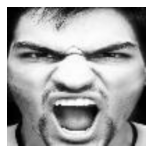

In [11]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import random

class_names = ['surprise', 'fear', 'disgust','happiness','sadness','anger','neutral']

random.seed(5)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [12]:
#for emotion conversion
def convertChineseEmotion(num):
    emotions = {
        1 : 'surprise', 
        2 : 'fear',
        3 : 'disgust',
        4 : 'happiness',
        5 : 'sadness',
        6 : 'anger',
        7 : 'neutral'
    }
    return emotions[num]

In [13]:
# DeepFace for the facial landmark vector and the race class
# train 2 different FCL NN for asian and western perspectives. 



In [14]:
%cd /content/aligned/
# %pwd

/content/aligned


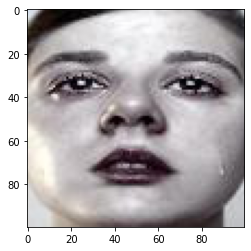

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('./aligned/train_00007.jpg')
imgplot = plt.imshow(img)
plt.show()

In [16]:
import glob

#path = '/content/aligned/aligned'
#items = []
#for files in glob.glob(path + '*.jpg'):
#    items.append(files)
 
#print(items)
face_vec = DeepFace.represent('./aligned/train_00007.jpg', model_name="VGG-Face", enforce_detection=False)

#face_race = DeepFace.analyze(items , detector_backend='retinaface', actions=['race'], enforce_detection=False)
#not going to run this now, but this allows us to racially classify every image using DeepFace. It may be better
# to use the model i stripped from 
print(len(face_vec))

2622


In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    break

(32, 224, 224, 3)


In [18]:
from deepface.basemodels import VGGFace

import os
from pathlib import Path
import gdown
import numpy as np
import zipfile

from deepface.commons import functions

import tensorflow as tf
tf_version = int(tf.__version__.split(".")[0])

if tf_version == 1:
	from keras.models import Model, Sequential
	from keras.layers import Convolution2D, Flatten, Activation
elif tf_version == 2:
	from tensorflow.keras.models import Model, Sequential
	from tensorflow.keras.layers import Convolution2D, Flatten, Activation

#url = 'https://drive.google.com/uc?id=1nz-WDhghGQBC4biwShQ9kYjvQMpO6smj'

def loadModel(url = 'https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5'):

	model = VGGFace.baseModel()

	#--------------------------

	classes = 6
	base_model_output = Sequential()
	base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
	base_model_output = Flatten()(base_model_output)
	base_model_output = Activation('softmax')(base_model_output)

	#--------------------------

	race_model = Model(inputs=model.input, outputs=base_model_output)

	#--------------------------

	#load weights

	home = str(os.getenv('DEEPFACE_HOME', default=Path.home()))

	if os.path.isfile(home+'/.deepface/weights/race_model_single_batch.h5') != True:
		print("race_model_single_batch.h5 will be downloaded...")

		output = home+'/.deepface/weights/race_model_single_batch.h5'
		gdown.download(url, output, quiet=False)

		"""
		#google drive source downloads zip
		output = home+'/.deepface/weights/race_model_single_batch.zip'
		gdown.download(url, output, quiet=False)

		#unzip race_model_single_batch.zip
		with zipfile.ZipFile(output, 'r') as zip_ref:
			zip_ref.extractall(home+'/.deepface/weights/')
		"""

	race_model.load_weights(home+'/.deepface/weights/race_model_single_batch.h5')

	return race_model

	#--------------------------

In [19]:
race_model = loadModel()

race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:08<00:00, 60.0MB/s]


(32, 6)


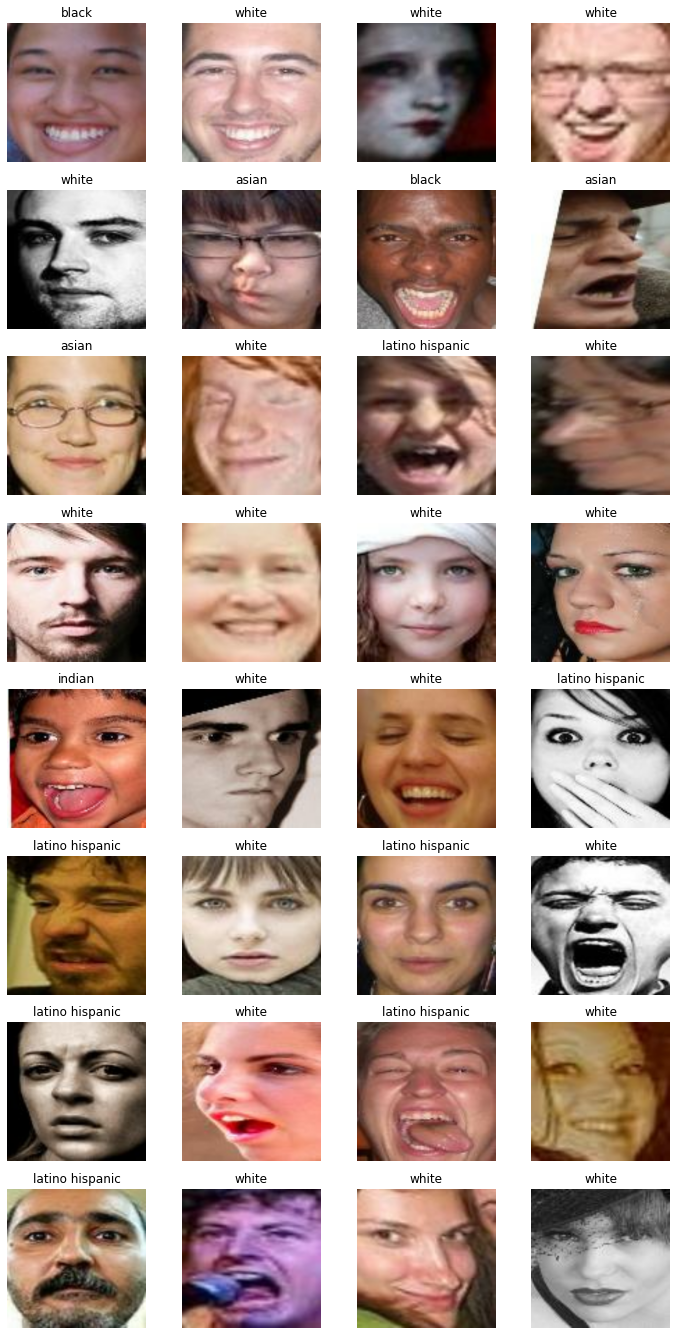

In [20]:
race_labels = ['asian', 'indian', 'black', 'white', 'middle eastern', 'latino hispanic']


random.seed(5)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
  outputs = race_model.predict(images)
  print(outputs.shape)
  count = 0;
  for arr in outputs:
        plt.subplot(n_rows, n_cols, count + 1)
        plt.imshow(images[count].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(race_labels[np.argmax(arr)], fontsize=12)
        count += 1
  # break
plt.subplots_adjust(wspace=.2, hspace=.2)

# for images, labels in train_ds.take(1):
#     outputs = race_model.predict(images)
#     for arr in outputs:
#         print()
#     break

In [21]:
%pwd

'/content/aligned'

In [22]:
def predict_race(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  return np.argmax(race_model.predict(img_batch))

(32, 6)


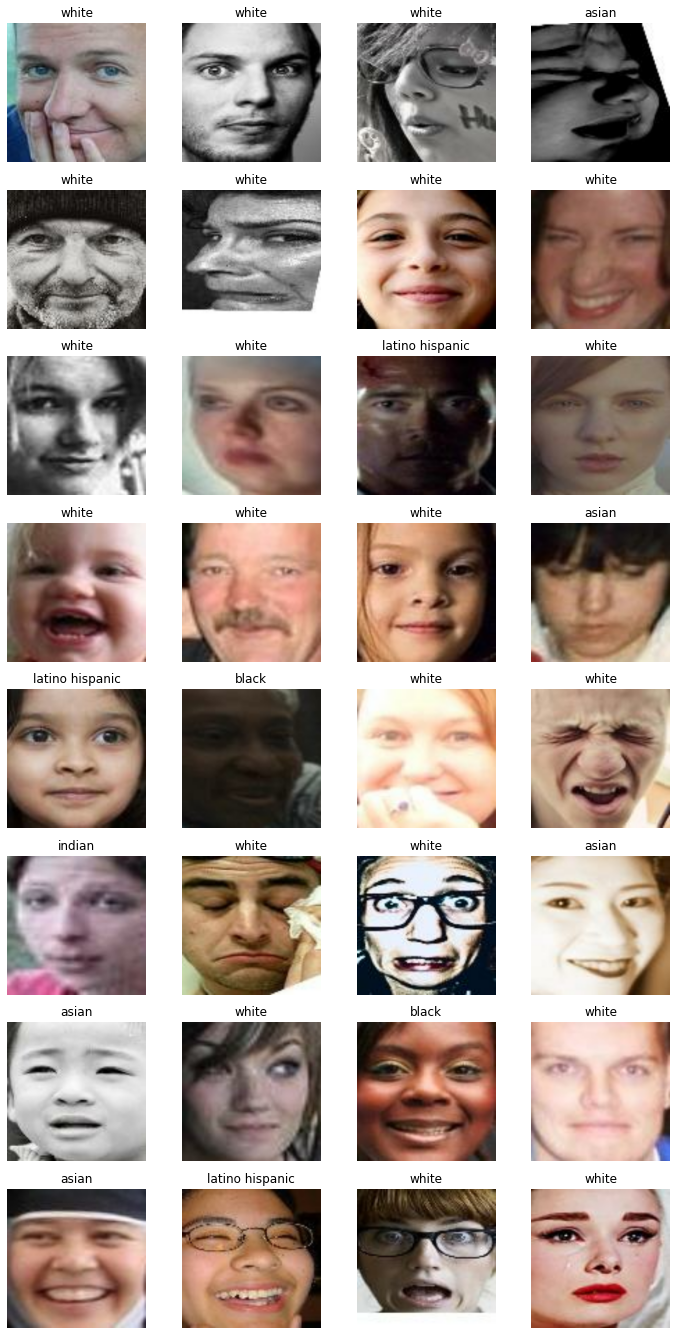

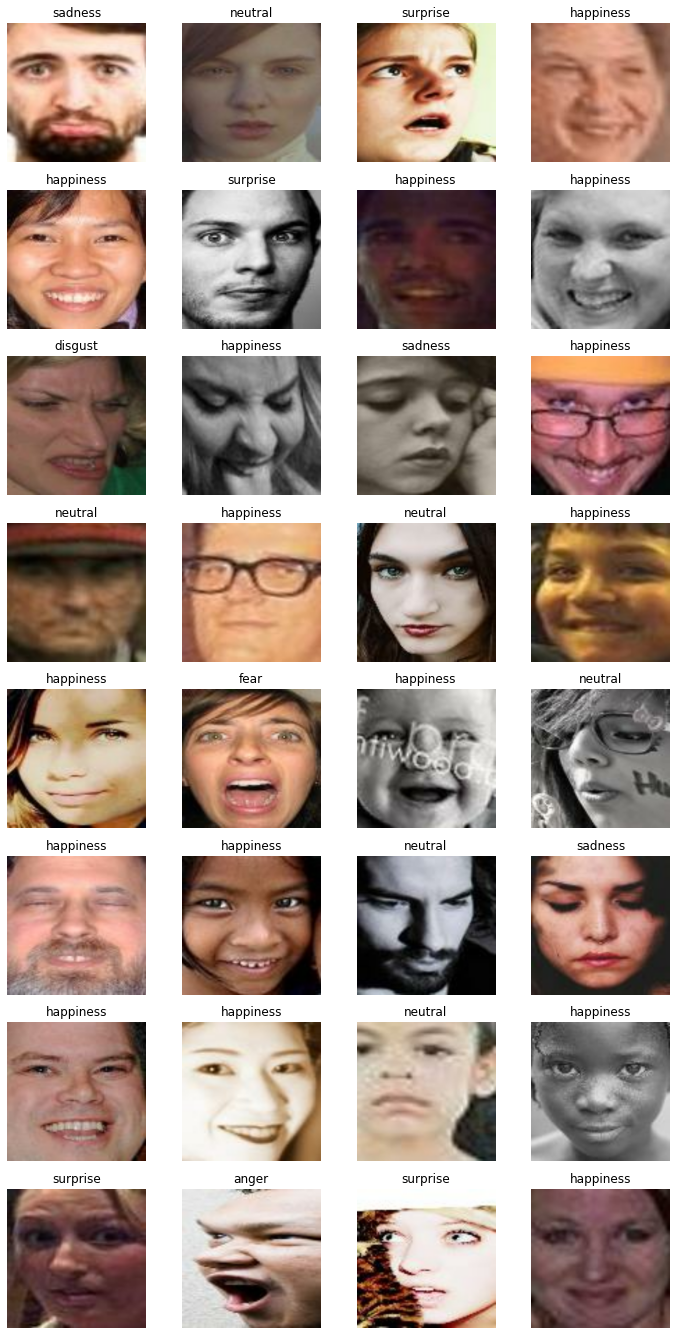

In [ ]:


random.seed(5)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
  outputs = race_model.predict(images)
  print(outputs.shape)
  count = 0;
  for arr in outputs:
        plt.subplot(n_rows, n_cols, count + 1)
        plt.imshow(images[count].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(race_labels[np.argmax(arr)], fontsize=12)
        count += 1
  # break
plt.subplots_adjust(wspace=.2, hspace=.2)


random.seed(5)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [ ]:
import shutil


labeled_path = '/content/aligned/labeled'

asian_path = labeled_path+ "/asian"
non_asian_path = labeled_path+ "/nonasian"

if not os.path.isdir(asian_path):
    os.mkdir(asian_path)
    os.mkdir(asian_path+"/1")
    os.mkdir(asian_path+"/2")
    os.mkdir(asian_path+"/3")
    os.mkdir(asian_path+"/4")
    os.mkdir(asian_path+"/5")
    os.mkdir(asian_path+"/6")
    os.mkdir(asian_path+"/7")

if not os.path.isdir(non_asian_path):
    os.mkdir(non_asian_path)
    os.mkdir(non_asian_path+"/1")
    os.mkdir(non_asian_path+"/2")
    os.mkdir(non_asian_path+"/3")
    os.mkdir(non_asian_path+"/4")
    os.mkdir(non_asian_path+"/5")
    os.mkdir(non_asian_path+"/6")
    os.mkdir(non_asian_path+"/7")


for dirs in os.listdir(labeled_path):
  

  if dirs == '1' or dirs == '2' or dirs == '3' or dirs == '4' or dirs == '5' or dirs == '6' or dirs == '7':
    # print(dirs)
    for items in os.listdir(labeled_path+"/"+dirs):
      if os.path.isfile(os.path.join(labeled_path+"/"+dirs, items)):
        
        item_path = labeled_path+"/"+dirs + "/"+items
        race = race_labels[predict_race(item_path)]
        

        if(race == 'asian'):
          dest = shutil.move(item_path, asian_path + "/" + dirs)
        else:
          dest = shutil.move(item_path, non_asian_path + "/" + dirs)




In [ ]:
!gdown https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo


Downloading...
From: https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo
To: /content/aligned/vgg_face_weights.h5
100% 580M/580M [00:03<00:00, 193MB/s]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K


# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights('vgg_face_weights.h5')

In [ ]:
# Remove last Softmax layer and get model upto last flatten layer #with outputs 2622 units 
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output) 
vgg_face.trainable=False

In [ ]:
data_dir = "/content/aligned/labeled/asian"
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
asian_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode = "int",
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width)
)

# Validation Dataset
asian_validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode = "int",
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width)
)

Found 1877 files belonging to 7 classes.
Using 1502 files for training.
Found 1877 files belonging to 7 classes.
Using 375 files for validation.


In [ ]:
# Asian Emotion Classifier

asian_emotion_model = Sequential([
                                  vgg_face,
                                  Dense(100, activation='relu'),
                                  BatchNormalization(),
                                  Dropout(.3),
                                  #Dense(35, activation='relu'),
                                  #BatchNormalization(),
                                  #Dropout(.3),
                                  Dense(7, activation='softmax'),
])

In [ ]:
asian_emotion_model.compile(optimizer='Adadelta',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
asian_emotion_model.fit(asian_train_ds, epochs=50, validation_data=asian_validation_ds)

Epoch 1/50
47/47 [==============================] - 8s 160ms/step - loss: 2.9317 - accuracy: 0.1225 - val_loss: 3.0846 - val_accuracy: 0.0987
Epoch 2/50
47/47 [==============================] - 8s 153ms/step - loss: 2.9285 - accuracy: 0.1265 - val_loss: 2.6332 - val_accuracy: 0.1120
Epoch 3/50
47/47 [==============================] - 8s 153ms/step - loss: 2.9411 - accuracy: 0.1112 - val_loss: 2.4736 - val_accuracy: 0.1360
Epoch 4/50
47/47 [==============================] - 8s 152ms/step - loss: 2.8568 - accuracy: 0.1158 - val_loss: 2.4033 - val_accuracy: 0.1467
Epoch 5/50
47/47 [==============================] - 7s 150ms/step - loss: 2.8464 - accuracy: 0.1418 - val_loss: 2.3587 - val_accuracy: 0.1707
Epoch 6/50
47/47 [==============================] - 7s 148ms/step - loss: 2.7647 - accuracy: 0.1405 - val_loss: 2.3301 - val_accuracy: 0.1707
Epoch 7/50
47/47 [==============================] - 7s 149ms/step - loss: 2.8066 - accuracy: 0.1372 - val_loss: 2.3067 - val_accuracy: 0.1680
Epoch 

In [42]:
RAF_labels = ["surprise", "fear", "disgust", "happy","sad","angry","neutral"]

In [ ]:
vgg_face.trainable=True

In [ ]:
asian_emotion_model.compile(optimizer='Adadelta',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
asian_emotion_model.fit(asian_train_ds, epochs=50, validation_data=asian_validation_ds)

Epoch 1/50
47/47 [==============================] - 23s 425ms/step - loss: 2.2169 - accuracy: 0.2743 - val_loss: 1.6838 - val_accuracy: 0.4080
Epoch 2/50
47/47 [==============================] - 19s 391ms/step - loss: 2.0978 - accuracy: 0.2876 - val_loss: 1.5935 - val_accuracy: 0.4667
Epoch 3/50
47/47 [==============================] - 19s 390ms/step - loss: 2.0002 - accuracy: 0.3269 - val_loss: 1.5633 - val_accuracy: 0.4853
Epoch 4/50
47/47 [==============================] - 19s 390ms/step - loss: 1.9688 - accuracy: 0.3442 - val_loss: 1.5237 - val_accuracy: 0.4880
Epoch 5/50
47/47 [==============================] - 19s 389ms/step - loss: 1.8581 - accuracy: 0.3628 - val_loss: 1.4774 - val_accuracy: 0.5173
Epoch 6/50
47/47 [==============================] - 19s 390ms/step - loss: 1.8674 - accuracy: 0.3708 - val_loss: 1.4328 - val_accuracy: 0.5413
Epoch 7/50
47/47 [==============================] - 19s 390ms/step - loss: 1.7723 - accuracy: 0.3928 - val_loss: 1.3954 - val_accuracy: 0.5600

In [47]:
results = [ [] for x in range(7)]
for dirs in os.listdir('/content/aligned/labeled/asian'):
  image_path = ['/content/aligned/labeled/asian/' + dirs + '/' + x for x in os.listdir('/content/aligned/labeled/asian/' + dirs) ]
  results[int(dirs)-1].append(DeepFace.analyze(image_path, actions=['emotion'], enforce_detection=False, detector_backend='retinaface')) 

Analyzing:   0%|          | 0/468 [00:00<?, ?it/s]

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  7%|▋         | 7.86M/119M [00:00<00:01, 65.5MB/s]
 14%|█▍        | 16.8M/119M [00:00<00:01, 60.9MB/s]
 20%|██        | 24.1M/119M [00:00<00:01, 62.3MB/s]
 28%|██▊       | 33.0M/119M [00:00<00:01, 63.4MB/s]
 34%|███▍      | 40.9M/119M [00:00<00:01, 67.8MB/s]
 41%|████      | 48.2M/119M [00:00<00:01, 65.5MB/s]
 46%|████▋     | 55.1M/119M [00:00<00:01, 62.2MB/s]
 53%|█████▎    | 62.9M/119M [00:00<00:00, 61.8MB/s]
 60%|██████    | 71.3M/119M [00:01<00:00, 67.5MB/s]
 66%|██████▋   | 78.6M/119M [00:01<00:00, 65.8MB/s]
 72%|███████▏  | 85.5M/119M [00:01<00:00, 63.0MB/s]
 80%|███████▉  | 94.4M/119M [00:01<00:00, 62.7MB/s]
 85%|████████▌ | 101M/119M [00:01<00:00, 62.6MB/s] 
 91%|█████████▏| 109M/119M [00:01<00:00, 63.1MB/s]
100%|██████████| 119M/119M [00:01<00:00, 62.4MB/s]
Analyzing: 100%|██████████| 120/12

In [49]:
count = 0
total = 0
for i, emote in enumerate(results):
  for instance in emote:
    for item in instance.items():
      total += len(item)
      if item[1]['dominant_emotion'] == RAF_labels[i]:
        count += 1

print('DeepFace Emotion Acc: ', count / total)
print('# classified', count, "total # of images", 1,877)


DeepFace Emotion Acc:  0.2674480554075653
# classified 1004 total # of images 1 877
